In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt

In [12]:
csv_path = "lung_and_colon_image_labels.csv"
df = pd.read_csv(csv_path)

label_mapping = {'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2, 'colon_n': 3, 'colon_aca': 4}
df['label'] = df['label'].map(label_mapping)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle with fixed seed

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

data_dir = "lung_colon_image_set/lung_colon_image"

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="file_name",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="file_name",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="validation",
    shuffle=False
)

Found 20000 validated image filenames.
Found 5000 validated image filenames.


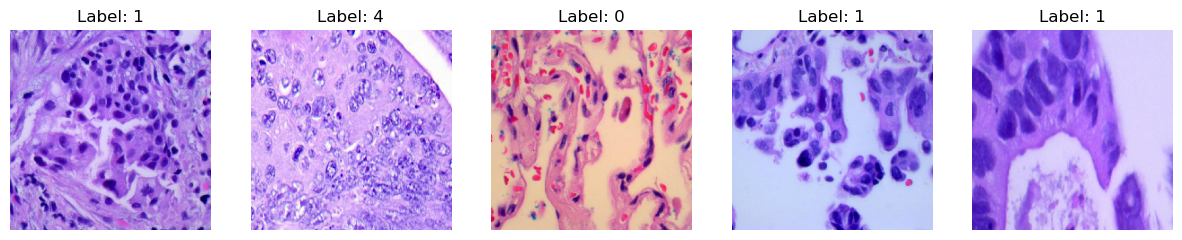

In [13]:
def plot_sample_images(generator, num_images=5):
    images, labels = next(generator)  # Fetch a batch
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i]}")

    plt.show()

# Check training data labels
plot_sample_images(train_generator, num_images=5)

In [14]:
# Build CNN Model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5, activation='softmax')  # 5 output classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
625/625 [==============================] - 718s 1s/step - loss: 0.4920 - accuracy: 0.7836 - val_loss: 0.2614 - val_accuracy: 0.8918
Epoch 2/10
625/625 [==============================] - 630s 1s/step - loss: 0.2395 - accuracy: 0.9055 - val_loss: 0.2461 - val_accuracy: 0.9000
Epoch 3/10
625/625 [==============================] - 599s 958ms/step - loss: 0.1608 - accuracy: 0.9374 - val_loss: 0.1584 - val_accuracy: 0.9392
Epoch 4/10
625/625 [==============================] - 590s 943ms/step - loss: 0.1170 - accuracy: 0.9559 - val_loss: 0.1504 - val_accuracy: 0.9448
Epoch 5/10
625/625 [==============================] - 687s 1s/step - loss: 0.0681 - accuracy: 0.9762 - val_loss: 0.1618 - val_accuracy: 0.9508
Epoch 6/10
625/625 [==============================] - 675s 1s/step - loss: 0.0570 - accuracy: 0.9790 - val_loss: 0.1510 - val_accuracy: 0.9536
Epoch 7/10
625/625 [==============================] - 670s 1s/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.2034 - val_accuracy: 

In [16]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

import numpy as np
y_true = df.iloc[val_generator.index_array]['label'].values
y_pred = np.argmax(model.predict(val_generator), axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label_mapping.keys()), labels=list(label_mapping.values())))

157/157 [==============================] - 72s 458ms/step - loss: 0.1668 - accuracy: 0.9610
Validation Accuracy: 0.9610
157/157 [==============================] - 74s 471ms/step
              precision    recall  f1-score   support

      lung_n       0.99      0.99      0.99       985
    lung_aca       0.94      0.93      0.93      1021
    lung_scc       0.94      0.95      0.94      1000
     colon_n       0.98      0.96      0.97       989
   colon_aca       0.96      0.98      0.97      1005

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

